## Содержание

[Библиотеки](#libraries)

[1. Подготовка данных и модели](#data_preparing)

[2. Подготовка признаковых описаний](#features_preparing)

[3. PCA](#pca)

<a id='libraries'></a>
## Библиотеки

In [42]:
import os

import torch
import numpy as np
from sklearn.decomposition import PCA

import dataset.default_augmentations as def_augs
import dataset.custom_datasets as cust_ds

import tools.utils.features_preparing as f_perp
from tools.utils.visualize_3d import plot_3d
from tools.vectorizer import Vectorizer

from models.triplet_loss import TripletLossModel
from models.triplet_loss_old import TripletLossModelOld
from models.triplet_loss_old import conv_simple_features_01
from models.triplet_loss_old import fully_connect_modul_266

In [43]:
%matplotlib notebook

<a id=data_preparing></a>
## 1. Подготовка данных и модели

**Датасет**

In [44]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
train_ds_path = os.path.join(datasets_path, 'sampled_train_marks_models')
test_ds_path = os.path.join(datasets_path, 'sampled_test')

In [102]:
def marks_indx_f(x):
    return (x[0],)

In [103]:
classif_ds_train = cust_ds.TLClassifyDataset(
    train_ds_path, marks_indx_f, crop=False,
    transform=def_augs.clTL_train_augs_128
)

classif_ds_test = cust_ds.TLClassifyDataset(
    test_ds_path, marks_indx_f, crop=False,
    transform=def_augs.clTL_test_augs_128
)

**Новая TL модель**

In [104]:
marks_features_len = 128
tl_mark_model = TripletLossModel(marks_features_len)

In [105]:
conv_block_wp = 'weights/2. triplet loss model - marks/1. 434 epochs/conv2Dfeatures_best_var.pt'
fc_block_wp = 'weights/2. triplet loss model - marks/1. 434 epochs/fully_connect_best_var.pt'

tl_mark_model.load_conv_block(conv_block_wp)
tl_mark_model.load_warmstart_fc_block(fc_block_wp)

**Старая TL модель**

In [106]:
IMAGE_SIZE = [128, 128, 1] 
device = 'cpu'
tl_models_old_marks = TripletLossModelOld(
    conv_simple_features_01,
    fully_connect_modul_266,
    IMAGE_SIZE, device=device,
    n_out=128)

weights_paths = [
    'weights/2. triplet loss model - marks/2. trained old/conv2Dfeatures.pt',
    'weights/2. triplet loss model - marks/2. trained old/fully_connect.pt']

tl_models_old_marks.conv_block.load_state(weights_paths[0],
                                          map_location=device)
tl_models_old_marks.fc_block.load_state(weights_paths[1],
                                        map_location=device)


Loading preset weights... Ok.

Loading preset weights... Ok.


<a id='features_preparing'></a>
## 2. Подготовка признаковых описаний

Подготовим признаковые описания для представления их в пространстве низкой размерности и дальнейшей визуализации.

In [107]:
collected = cust_ds.collect_dataset(train_ds_path, marks_indx_f)
train_images, train_labels, train_labels_code = collected
train_labels_code_out = {v: k for k, v in train_labels_code.items()}

In [108]:
n_classes = 3
n_images = 100
u = f_perp.chose_objects(train_images, train_labels, train_labels_code,
                         n_classes, n_images, random_state=7)

In [109]:
u_images, u_labels = f_perp.transform_chosen_objects(u)

Набазе старой модели:

In [110]:
vectorizer_old = Vectorizer()
vectorizer_old.vectorize_from_paths(u_images,
                                    tl_models_old_marks,
                                    crop=True,
                                    labels=torch.tensor(u_labels))

  0%|          | 0/300 [00:00<?, ?it/s]

Набазе новой модели:

In [111]:
vectorizer_new = Vectorizer()
vectorizer_new.vectorize_from_paths(u_images,
                                    tl_mark_model,
                                    crop=True,
                                    labels=torch.tensor(u_labels))

  0%|          | 0/300 [00:00<?, ?it/s]

<a id='pca'></a>
## 3. PCA

Старая модель:

<IPython.core.display.Javascript object>


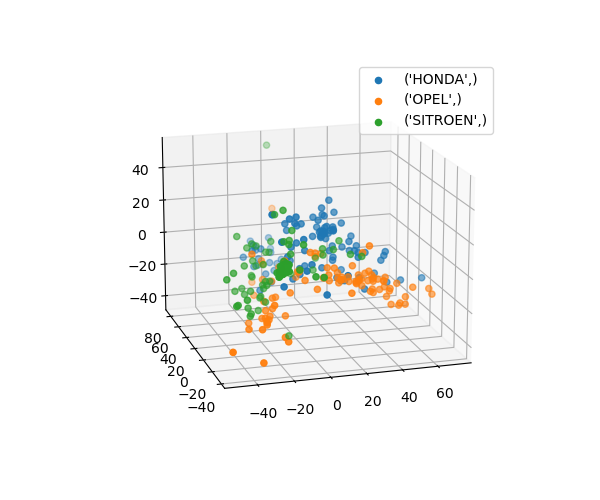

In [112]:
pca_n_components = 3
pca = PCA(pca_n_components)
pca_3_dim = pca.fit_transform(vectorizer_old.vects_from_paths_res.numpy())
plot_3d(pca_3_dim, np.array(u_labels), train_labels_code_out)

Новая модель:

<IPython.core.display.Javascript object>


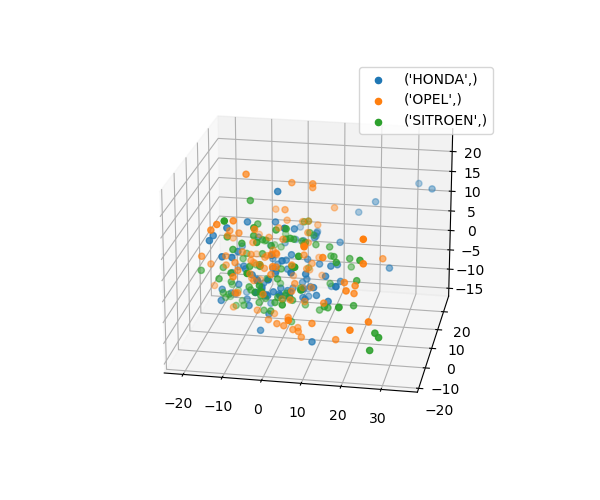

In [113]:
pca_n_components = 3
pca = PCA(pca_n_components)
pca_3_dim = pca.fit_transform(vectorizer_new.vects_from_paths_res.numpy())
plot_3d(pca_3_dim, np.array(u_labels), train_labels_code_out)